# Image Classification with ArcFace Loss

In this notebook we will train SOTA Computer Vision models (such as MobileNet, EfficientNet) to classify car brands. We will ArcFace Loss function for this task, which is also state-of-art.

# 1. Set up

## 1. Packages and requirements

In [1]:
# Major builtin libraries
import os
import gc
# import cv2
import math
import time
import random
import typing as t
from copy import deepcopy
# from collections import defaultdict

In [2]:
# To work with Google Collab
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

In [3]:
import warnings  # If you want to disable warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# Classic packages for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Basic PyTorch
import torch
import torch.nn as nn
import torch.optim as optim  # Optimization algorithms and dynamic learning rate adjusting
import torch.nn.functional as F
# from torch.nn.modules.loss import _Loss  # For writing a custom Loss function
from torch.utils.data import DataLoader, Dataset  # For custom data presentation

In [6]:
# Utils
import joblib  # Pipelining, pickling (dump/load), parallel processing
from tqdm import tqdm  # Progress bar for training process
from tempfile import TemporaryDirectory

# Classic ML tools
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold  # Cross-Validation

In [7]:
# Data dimensionality reduction
from sklearn.manifold import TSNE  # high-dimensional data visualization
from sklearn.decomposition import PCA  # More effective dimensionality reduction method

# kNN classification
from sklearn.neighbors import KNeighborsClassifier

# Clustering methods
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [8]:
# !pip install torchmetrics colorama

In [9]:
# ML Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from torchmetrics.classification import MulticlassF1Score # F1 metric for multiclass

In [10]:
# Torch Computer Vision tools for images processing
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image, to_grayscale, to_tensor
from torchvision import models  # Pretrained models

In [11]:
# Albumentations is an OS library for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
# import torchvision.transforms as T  # We can use torch augmentations instead

In [12]:
# Output text colorizing
from colorama import Back, Style

def print_highlighted(text: str, bgcolor=Back.YELLOW) -> None:
    """
    Function to print a text with colored background.
    """
    print(bgcolor + text + Style.RESET_ALL)

In [13]:
# import wandb # MLOps platform to simplify and speed up the process of building ML models

In [14]:
# wandb.login() # We log in via pop-up,
# wandb.login(key=api_key)  # but you can also log in manually with function args

## 2. Configuration

In [15]:
CONFIG = {
    "seed": 2306,
    "epochs": 20,
    "image_dimension": 256,  # Depends on pretrained model used
    "model_name": "efficientnet_b0",  # Pretrained model we will use
    "embedding_size": 512,  # Embedding output size
    "train_batch_size": 64,
    "val_batch_size": 128,
    "learning_rate": 1e-3,
    "min_lr": 1e-8,
    "min_loss_delta": 1e-7, # To stop training on plateau
    "weight_decay": 1e-7,
}

In [16]:
class Config:
    """
    Class to simplify access to Config: not dict but object with attributes
    """
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

In [17]:
config = Config(config_dict=CONFIG)
del CONFIG

In [18]:
# Work example
config.seed

2306

Set Seed for Reproducibility

In [19]:
def set_seed(seed=42):
    """
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)

    # When running on the CuDNN backend, two further options must be set
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False  # When False, this option makes CUDA reproducible, BUT the performance might suffer

    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(seed=config.seed)

# 2. Data

## 1. Location

In [20]:
config.repo = '760-data-cars/'  # dataset name on Kaggle
# config.repo = 'data/'  # dataset name on local device
# config.repo = 'car_brand_detection/'  # Google Collab

config.root = '/kaggle/input/' + config.repo
# config.root = 'drive/MyDrive/' + config.repo
# config.root = '../'  + config.repo


config.data = config.root

config.train_images_path  = config.data + 'all_cars_yolodata/train'
config.test_images_path = config.data + 'all_cars_yolodata/test'

config.train_labels  = config.data + 'train_labels.csv'
config.test_labels = config.data + 'test_labels.csv'

# config.model_path = 'fine-tuned_mobilenet_v2'
config.model_path = '/kaggle/input/arcface-params-and-efficient/fine-tuned_efficientnet_b0.pth'
# config.arcface_weights = '/kaggle/input/efficient-model/ArcLoss_parametres.pth'
# config.model_path = '/kaggle/input/efficient-model/ArcFace_efficientnet_b0.pth'

## 2. Custom Data representation

In [21]:
def get_file_path_by_id(file_id, dir=config.root):
    return os.path.join(dir, str(file_id) + ".jpg")

In [22]:
def apply_label_encoding(data: t.Union[pd.DataFrame, np.array],
                         encoder_name: os.path,
                         column='label', action='encode',
                         ):
    """
    One Hot encoding. We apply encoding by replacing the label column in dataframe.
    As for decoding data back, we work with vector-array (as it's most likely to
    be a prediction result)
    """
    encoder = LabelEncoder()
    if action == 'encode':
        # We transform dataframe here. Nothing returns
        data[column] = encoder.fit_transform(data[column])
        with open(f"{encoder_name}_LEncoder.pkl", "wb") as fp:
            joblib.dump(encoder, fp)
    elif action == 'decode':
        # We pass vector here. Result is a vector
        with open(f"{encoder_name}_LEncoder.pkl", "rb") as fp:
            encoder: LabelEncoder = joblib.load(fp)
        return encoder.inverse_transform(data)

In [23]:
class CustomImagesDataset(Dataset):
    """
    """
    def __init__(self, data: pd.DataFrame=None, images_path: os.path=None, labels_path:os.path=None, transform_images: A.Compose=None, encoder_name: str=None):
        """

        """
        super().__init__()
        assert (data is not None) or (labels_path is not None and images_path is not None)

        if data is None:
            data = pd.read_csv(labels_path)
            data['file_path'] = data['id'].apply(get_file_path_by_id, dir=images_path)

        self.images_paths = data['file_path'].values
        self.encoder_name = encoder_name if encoder_name else self.__hash__()  # We use hash as a unique name
        print_highlighted(f"Label Encoder saved with id `{self.encoder_name}`")
        apply_label_encoding(data=data, action='encode', encoder_name=self.encoder_name)
        self.labels = data['label'].values
#         self.indexes = data['id'].values
        self.transform_images = transform_images
        self.__set_dataset_len()

    def __set_dataset_len(self):
        self.length = self.labels.shape[0] # Number of rows

    def __len__(self):
        """
        We calculate the len in another function, so that we are able to slice.
        """
        return self.length

    def decode_labels(self, labels_vector):
        return apply_label_encoding(data=labels_vector, action='decode', encoder_name=self.encoder_name)

    def __getitem__(self, index) -> tuple[torch.Tensor, int]:
        """ Function to return item by indexing the dataset """

        if not isinstance(index, int) and isinstance(index, slice):
            # It's not an index, but slice.
            # We will return the part of data by making a copy of the dataset
            index: slice
            self = deepcopy(self)
            self.length = index.stop  # Cut the length of dataset.
            self.labels = self.labels[:self.length]
            return self
        assert self.__len__() >= index

        image = to_pil_image(read_image(self.images_paths[index]))
        if self.transform_images:
            # Albumentations requires us to convert image to Numpy Array
            image = self.transform_images(image=np.array(image))['image']

        label = self.labels[index]
        return image, label


    @property
    def classes_(self):
        return self.decode_labels(np.unique(self.labels))


## 3. Augmentations

We use Albumantations lib

In [24]:
data_transforms = {
    "train": A.Compose([
#         A.ToRGB(),
        A.Resize(config.image_dimension, config.image_dimension),
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.15,
            rotate_limit=30,
            p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=30,
                sat_shift_limit=30,
                val_shift_limit=30,
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.01,0.01),
                contrast_limit=(-0.01, 0.01),
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2() # Advanced analogue of T.ToTensor
    ], p=1.),

    "val": A.Compose([
#         A.ToRGB(),
        A.Resize(config.image_dimension, config.image_dimension),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

## 4. Load the data and have a look

In [25]:
train_dataset = CustomImagesDataset(labels_path=config.train_labels, images_path=config.train_images_path, transform_images=data_transforms['train'], encoder_name='train')

Label Encoder saved with id `train`


In [26]:
test_dataset = CustomImagesDataset(
    labels_path=config.test_labels,
    images_path=config.test_images_path,
    transform_images=data_transforms['val'],
    encoder_name='test',
)

Label Encoder saved with id `test`


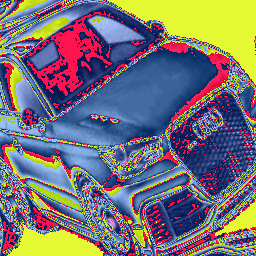

In [27]:
to_pil_image(train_dataset[60][0])

In [28]:
config.num_of_classes = len(train_dataset.classes_)
config.num_of_classes

760

Below we ensure that the test dataset doesn't contain unknown data

In [29]:
assert not bool(set(test_dataset.classes_) - set(train_dataset.classes_))

In [30]:
print(*train_dataset.classes_[:20], sep=';  ', end='...')

Acura_MDX;  Alfa Romeo_Giulietta;  Audi_100;  Audi_80;  Audi_A1;  Audi_A3;  Audi_A4;  Audi_A5;  Audi_A6;  Audi_A7;  Audi_A8;  Audi_Q3;  Audi_Q5;  Audi_Q7;  Audi_R8;  Audi_RS6;  Audi_S5;  Audi_S8;  Audi_TT;  BAW_FENIX...

# 3. Model

ArcFace loss function is used on the embeddings, not on the final predictions

## 1. Getting the pretrained model

In [31]:
def get_input_feature_size(classifier: nn.Sequential) -> int:
    for module in classifier.modules():
        if isinstance(module, nn.Linear):
            return module.in_features

In [32]:
def get_model(model_name='resnet18', from_path=None, pretrained=False, freeze_layers=0.0, get_embeddings=False) -> torch.nn.Module:
    if from_path:
        try:
            model = torch.load(from_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        except FileNotFoundError:
            raise
    elif model_name:
        model = getattr(models, model_name) # We use builtin function
        model = model(
        weights=('DEFAULT' if pretrained else None)
        )

    if bool(freeze_layers):
        params = list(model.parameters())
        for param in params[:int(len(params)*freeze_layers)]:
            # Freeze some layers
            param.requires_grad = False

    if get_embeddings:
        # That means remove classifier (last layer):
        model.classifier = nn.Sequential(
            # nn.Dropout(p=0.3, inplace=True),
            nn.Linear(in_features=get_input_feature_size(model.classifier),
                      out_features=config.embedding_size, bias=True
                      ),

        )
    return model

We can fine-tune the model or train from scratch

In [33]:
# model = get_model(
#     model_name=config.model_name,
#     pretrained=True,
#     freeze_layers=0.0,
#     get_embeddings=True
# )

Or fine-tine the model that we've trained before

In [34]:
model = get_model(
    from_path=config.model_path,
    pretrained=True,
    freeze_layers=0.0,
    get_embeddings=True
)

It is a model that doesn't have classifier - only one linear layer that transforms embeddings to desired size

In [35]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [36]:
@torch.inference_mode()
def accuracy(model, loader):
    model.eval()
    target = []
    labels = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        
        output = model(x)
        _, y_pred = torch.max(output, dim=1)
        
        target.append(y)
        labels.append(y_pred)
    return (torch.cat(target) == torch.cat(labels)).sum() / len(torch.cat(labels))

In [37]:
model = torch.load('/kaggle/input/models/fine-tuned_efficientnet_b0.pth')

In [38]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=760, bias=True)
  (2): Softmax(dim=-1)
)

In [39]:
model.classifier = nn.Sequential(
                   nn.Dropout(0.2, inplace=True),
                   nn.Linear(1280, 512),
                   )

In [40]:
#accuracy(model, test_dataloader)

# 4. Various

## 1. Quality metrics

We will use accuracy and F1 score for out classification task

In [41]:
f1_score = MulticlassF1Score(num_classes=config.num_of_classes, average="macro")

## 2. Device

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
f1_score = f1_score.to(device)
torch.cuda.empty_cache()

## 3. Data processing format

In [43]:
config.train_batch_size, config.val_batch_size = 128, 128

In [44]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=config.train_batch_size,
                              shuffle=True,
                              num_workers=os.cpu_count() % 4,
)

In [45]:
test_dataloader = DataLoader(test_dataset,
                              batch_size=config.val_batch_size,
                              shuffle=False,
                              num_workers=os.cpu_count() % 4,
)

# 5. Embeddings processing

In [46]:
@torch.inference_mode()
def get_embeddings(model, dataloader, device):
    model.eval()
    all_embeddings = []
    all_labels = []

    with tqdm(dataloader, desc="Processing",unit="batch") as process:
        for images, labels in process:
            images = images.to(device)
            labels = labels.to(device)
            embeddings = model(images)

            all_embeddings.extend(tuple(embeddings.cpu().numpy()))
            all_labels.extend(tuple(labels.cpu().numpy()))

    return np.squeeze(np.array(all_embeddings)), np.array(all_labels)
    return np.squeeze(np.array(embeddings))

In [47]:
# embeddings_bag, labels = get_embeddings(model, test_dataloader, device)

In [48]:
def reduce_dimension(dimension, features, reduce_with='pca',) -> np.array:
    """ Perform dimensionality reduction with PCA or t-SNE """

    assert reduce_with.lower() in ['pca', 'tsne']

    if reduce_with.lower() == 'tsne':
        reductor = TSNE(n_components=dimension, perplexity=2.0)
    else: # PCA
        reductor = PCA(n_components=dimension)

    reduced_features = reductor.fit_transform(features)
    return reduced_features

In [49]:
def visualize_embeddings(embeddings, labels, reduce_with='pca', save_as: str=None,):
    """
    To project the embeddings vectors onto a low-dimensional space (2d or 3d)
    :param embeddings:
    :param labels:
    :param reduce_with:
    :param save_as:
    :return:
    """
    assert reduce_with in ['pca', 'tsne']

    embeddings = embeddings.squeeze()

    embeddings_2d = reduce_dimension(
        dimension=2,
        features=embeddings,
        reduce_with=reduce_with
    )
    embeddings_3d = reduce_dimension(
        dimension=3,
        features=embeddings,
        reduce_with=reduce_with
    )

    # Plot the dots in 3D or 2D
    fig = plt.figure(figsize=(16,6))
    # ----------------------------------------------- #

    # 2D
    ax = fig.add_subplot(1,3,1)
    dots = (embeddings_2d[:, 0], embeddings_2d[:, 1])
    ax.scatter(*dots, c=labels, cmap='viridis')
    ax.set_title('2D')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    # ----------------------------------------------- #

    # Hypersphere
    ax = fig.add_subplot(1,3,2, projection='3d')
    r = 1.0  # Radius
    pi = np.pi
    cos = np.cos
    sin = np.sin

    # Surface
    phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
    x = r*sin(phi)*cos(theta)
    y = r*sin(phi)*sin(theta)
    z = r*cos(phi)
    ax.plot_surface(
        x, y, z,  rstride=1, cstride=1, color='w', alpha=0.3, linewidth=0
    )

    phi = embeddings_2d[:, 0] * 2 * pi
    theta = (embeddings_2d[:, 1] - 0.5) * 2 * pi
    # Embeddings dots
    x = r * sin(theta) * cos(phi)
    y = r * sin(theta) * sin(phi)
    z = r * cos(theta)

    dots = (x, y, z)
    ax.scatter(*dots, c=labels, cmap='viridis', s=20)
    ax.set_title('Sphere distribution')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    # ----------------------------------------------- #


    # Simple 3D
    ax = fig.add_subplot(1,3,3, projection='3d')
    dots = (embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2])
    ax.scatter(*dots, c=labels, cmap='viridis')
    ax.set_title('3D')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')


    if save_as:
        plt.savefig(f'{save_as}.png')
    plt.tight_layout()
    plt.show()


In [50]:
# visualize_embeddings(
#     embeddings_bag[:100],
#     labels[:100],
#     reduce_with='tsne',
#     # reduce_with='pca',
# )

# 5. Initialize the train process

## 1. Functions to plot the result

In [51]:
def plot_two_curves(
        title: str,
        train_curve: list[float],
        val_curve: list[float],

):
    plt.figure(figsize=(16, 8))
    plt.title(title)
    plt.plot(train_curve, label=f'Train {title}')
    plt.plot(val_curve, label=f'Valid {title}')
    plt.legend()
    plt.grid()
    plt.show()
    #plt.savefig(title)

In [52]:
def plot_stats(
        train_loss: list[float],
        valid_loss: list[float],
        train_accuracy: list[float]=None,
        valid_accuracy: list[float]=None,
        train_f1_score: list[float]=None,
        valid_f1_score: list[float]=None,
        title: str = None
):
    plot_two_curves(
        'Loss',
        train_loss,
        valid_loss
    )

    if train_accuracy and valid_accuracy:
        plot_two_curves(
            'accuracy',
            train_accuracy,
            valid_accuracy
        )

    if train_f1_score and valid_f1_score:
        plot_two_curves(
            'F1 score',
            train_f1_score,
            valid_f1_score
        )


## 2. Training and evaluation functions

In [53]:
def train_one_epoch(model, dataloader, optimizer, criterion, device, epoch: str):
    model.train()

    train_loss = 0.0
    train_correct = 0.0
    train_f1 = 0.0
    n_batches = 0
    data_size = 0

    with tqdm(dataloader, desc=f'Epoch: {epoch}', unit="batch") as tepoch:
        for images, labels in tepoch:
            n_batches += 1
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Our model returns embeddings (instead of predictions).
            embeddings = model(images)

            # But we still want to calculate accuracy, so, we calculate probs it our ArcFace Function
            probabilities = criterion(embeddings, labels)
            loss = F.cross_entropy(probabilities, labels)
            loss.backward()

            optimizer.step()

            loss = loss.item()  # item() extracts scalar
            train_loss += loss

            _, predicted = torch.max(probabilities, 1)

            train_correct += (predicted == labels).sum().item()
            data_size += labels.size(0)
            train_accuracy = train_correct / data_size

            f1 = f1_score(predicted, labels).item()
            train_f1 += f1
            tepoch.set_postfix(loss=loss, acc=train_accuracy)

    train_loss /= n_batches
    train_f1 /= n_batches
    gc.collect()
    torch.cuda.empty_cache()

    return train_loss, train_accuracy, train_f1

In [54]:
@torch.inference_mode()
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()

    val_loss = 0.0
    val_correct = 0.0
    val_f1_score = 0.0
    data_size = 0
    n_batches = 0

    with tqdm(dataloader, desc="Validation",unit="batch") as tepoch:
        for images, labels in tepoch:
            n_batches += 1
            images = images.to(device)
            labels = labels.to(device)
            embeddings = model(images)

            probabilities = criterion(embeddings, labels)
            loss = F.cross_entropy(probabilities, labels).item()
            val_loss += loss

            _, predicted = torch.max(probabilities, 1)

            correct = (predicted == labels).sum().item()
            val_correct += correct
            data_size += labels.size(0)
            val_accuracy = val_correct / data_size

            f1 = f1_score(predicted, labels).item()
            val_f1_score += f1
            tepoch.set_postfix(loss=loss, acc=val_accuracy)

    val_loss /= n_batches
    val_f1_score /= n_batches
    gc.collect()
    torch.cuda.empty_cache()

    return val_loss, val_accuracy, val_f1_score

## 3. Training cycle

In [55]:
def train_model(model, train_loader, val_loader,
                criterion=None, optimizer=None, num_epochs=5,
                scheduler=None, device=torch.device("cpu"),
                save_model_to=None, save_margin_parameters_to=None):
    since = time.time()

    train_loss_history, valid_loss_history = [], []
    train_acc_history, valid_acc_history = [], []
    train_f1_history, valid_f1_history = [], []


    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        for epoch in range(num_epochs):
            train_loss, train_accuracy, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch=f'{epoch+1}/{num_epochs}')
            val_loss, val_accuracy, val_f1 = validate_one_epoch(model, val_loader, criterion, device,)


            print_highlighted(
                f"Loss: {val_loss:.4f} - Accuracy: {val_accuracy:.4f} - F1: {val_f1:.4f} - LR: {get_lr(optimizer)}"
            )

            if not valid_loss_history or val_loss < valid_loss_history[-1]:
                # If it's either first step (history is empty) or our weights are getting better
                print_highlighted("New weights were applied.\n", bgcolor=Back.CYAN)
                torch.save(model.state_dict(), best_model_params_path)

            scheduler.step(val_loss)

            train_loss_history.append(train_loss)
            valid_loss_history.append(val_loss)
            train_acc_history.append(train_accuracy)
            valid_acc_history.append(val_accuracy)
            train_f1_history.append(train_f1)
            valid_f1_history.append(val_f1)

            del train_loss
            del val_loss
            gc.collect()
            torch.cuda.empty_cache()

        time_elapsed = time.time() - since
        print_highlighted(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

        if save_model_to:
            torch.save(model, save_model_to)
            print(f"Model was saved to: {save_model_to}")
        if save_margin_parameters_to:
            torch.save(criterion.state_dict(), save_margin_parameters_to)
            print(f"Loss Function weights were saved to: {save_margin_parameters_to}")


        history = dict(
            train_loss=train_loss_history,
            valid_loss=valid_loss_history,
            train_accuracy=train_acc_history,
            valid_accuracy=valid_acc_history,
            train_f1_score=train_f1_history,
            valid_f1_score=valid_f1_history,
        )
    return model, history

# 6. Hyperparametres

## 1. ArcFace Loss

Custom Loss Function

$$L = - \frac{1}{N} \sum_{i=1}^{N}\; \log \frac{e^{s(\cos(\theta_{y_i} +m))}}
{e^{s\cos(\theta_{y_i} +m)} + \sum_{j=1, j\neq {y_i}}^{n} e^{s\cos(\theta_{j})}}$$

In [56]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin

            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.ones([out_features, in_features], dtype=torch.float32, device=device))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))

        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
            
#         print("PHI IS: ", phi)


        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device=device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s
        # loss = F.cross_entropy(output, label)

        return output

In [57]:
class ArcFaceLoss(nn.Module):
    def __init__(self, embedding_size, num_classes, margin=0.5, scale=64):
        super().__init__()
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.margin = margin
        self.scale = scale
        self.weight = nn.Parameter(torch.ones([num_classes, embedding_size], dtype=torch.float32, device=device))
        nn.init.xavier_uniform_(self.weight)
        self.easy_margin = False
        
#         self.cos_m = math.cos(margin)
#         self.sin_m = math.sin(margin)
#         self.th = math.cos(math.pi - margin)
#         self.mm = math.sin(math.pi - margin) * margin
        
    def forward(self, embeddings, labels):
        # Normalize the embeddings and weights
        labels = labels.to(torch.long)

        embeddings = F.normalize(embeddings, dim=1)
        weights = F.normalize(self.weight, dim=1)

        # Compute the cosine similarity between embeddings and weights
        cosine = F.linear(embeddings, weights)
        
        # Calculate the theta (angle) values for each class
        theta = torch.acos(torch.clip(cosine, -1 + 1e-7, 1 - 1e-7))

        # Apply the ArcFace margin and calculate logits
        
        one_hot_labels = F.one_hot(labels, self.num_classes)
        
#         target_logits = torch.cos(theta + self.margin)

        # Easy margin
        target_logits = torch.cos(theta + self.margin * (1 - one_hot_labels.float()))

        logits = self.scale * torch.where(one_hot_labels.bool(), target_logits, cosine)

        probabilities = F.softmax(logits, dim=1)
        return probabilities  # We will calculate the cross-entropy loss later
    

In [58]:
# criterion3 = nn.CrossEntropyLoss()
# # criterion = losses.ArcFaceLoss(
# #     num_classes=config.num_of_classes,
# #     embedding_size=config.embedding_size
# # )
# criterion2 = ArcMarginProduct(
#     in_features=config.embedding_size, 
#     out_features=config.num_of_classes,
# )

In [59]:
criterion = ArcFaceLoss(
    embedding_size=config.embedding_size,
    num_classes=config.num_of_classes,
)
try:
    # Load weights
    criterion.load_state_dict(torch.load('/kaggle/input/arcface-params-and-efficient/Trained_ArcLoss_parameters.pth'))
except FileNotFoundError:
    pass

In [60]:
config.learning_rate = 5e-4
config.epochs = 30
config.weight_decay = 1e-7
config.min_loss_delta = 0.05

In [61]:
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config.learning_rate, weight_decay = config.weight_decay)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
# optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.8)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [62]:
optimizer = torch.optim.Adam(
    [
    {'params': filter(lambda p: p.requires_grad, model.features.parameters())},
    {'params': model.classifier.parameters()},
    {'params': criterion.parameters(), 'lr': 0.01}
    ],
    lr=config.learning_rate, 
    weight_decay = config.weight_decay)


In [63]:
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5, verbose=False)


scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', patience = 5, factor=0.5, 
    min_lr=config.min_lr , verbose=False,
    threshold = config.min_loss_delta
)


# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5, verbose=False)
# scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.5, verbose=False)

In [64]:
def get_lr(optimizer):
    """
    For some schedulers we don't have `get_last_lr()` method.
    So, we will get last lr ourselves.
    """
    return list(
        [group['lr'] for group in optimizer.param_groups]
    )

In [65]:
get_lr(optimizer)

[0.0005, 0.0005, 0.01]

# 7. Run the training process

In [66]:
config.epochs = 40

In [67]:
model_file_name = f'ArcFace_{config.model_name}.pth'
arcface_parameters = 'Trained_ArcLoss_parameters.pth'

model, history = train_model(
    model=model,
    train_loader=train_dataloader,
    val_loader=test_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=config.epochs,
    device=device,
    scheduler=scheduler,
    save_model_to=model_file_name,
    save_margin_parameters_to=arcface_parameters
 )

Validation: 100%|██████████| 22/22 [00:17<00:00,  1.25batch/s, acc=0.681, loss=6.02]


Loss: 5.9686 - Accuracy: 0.6814 - F1: 0.4366 - LR: [0.0005, 0.0005, 0.01]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:12<00:00,  1.78batch/s, acc=0.71, loss=6]


Loss: 5.9374 - Accuracy: 0.7099 - F1: 0.4764 - LR: [0.0005, 0.0005, 0.01]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:12<00:00,  1.83batch/s, acc=0.742, loss=6.01]


Loss: 5.9060 - Accuracy: 0.7423 - F1: 0.5088 - LR: [0.0005, 0.0005, 0.01]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:12<00:00,  1.77batch/s, acc=0.747, loss=5.95]


Loss: 5.8940 - Accuracy: 0.7467 - F1: 0.5154 - LR: [0.0005, 0.0005, 0.01]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:12<00:00,  1.82batch/s, acc=0.763, loss=5.99]


Loss: 5.8838 - Accuracy: 0.7632 - F1: 0.5463 - LR: [0.0005, 0.0005, 0.01]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:12<00:00,  1.81batch/s, acc=0.761, loss=5.95]


Loss: 5.8844 - Accuracy: 0.7607 - F1: 0.5399 - LR: [0.0005, 0.0005, 0.01]


Validation: 100%|██████████| 22/22 [00:11<00:00,  1.93batch/s, acc=0.748, loss=5.97]


Loss: 5.8963 - Accuracy: 0.7485 - F1: 0.5152 - LR: [0.0005, 0.0005, 0.01]


Validation: 100%|██████████| 22/22 [00:11<00:00,  1.98batch/s, acc=0.802, loss=5.89]


Loss: 5.8399 - Accuracy: 0.8018 - F1: 0.5951 - LR: [0.00025, 0.00025, 0.005]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:11<00:00,  1.88batch/s, acc=0.816, loss=5.92]


Loss: 5.8279 - Accuracy: 0.8159 - F1: 0.6226 - LR: [0.00025, 0.00025, 0.005]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:11<00:00,  1.93batch/s, acc=0.812, loss=5.88]


Loss: 5.8298 - Accuracy: 0.8115 - F1: 0.6039 - LR: [0.00025, 0.00025, 0.005]


Validation: 100%|██████████| 22/22 [00:11<00:00,  1.93batch/s, acc=0.819, loss=5.9]


Loss: 5.8250 - Accuracy: 0.8191 - F1: 0.6220 - LR: [0.00025, 0.00025, 0.005]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:11<00:00,  1.86batch/s, acc=0.815, loss=5.89]


Loss: 5.8267 - Accuracy: 0.8155 - F1: 0.6186 - LR: [0.00025, 0.00025, 0.005]


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.81batch/s, acc=0.812, loss=5.92]


Loss: 5.8328 - Accuracy: 0.8115 - F1: 0.6176 - LR: [0.00025, 0.00025, 0.005]


Validation: 100%|██████████| 22/22 [00:11<00:00,  1.84batch/s, acc=0.821, loss=5.91]


Loss: 5.8224 - Accuracy: 0.8205 - F1: 0.6335 - LR: [0.000125, 0.000125, 0.0025]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:11<00:00,  1.85batch/s, acc=0.83, loss=5.9]


Loss: 5.8126 - Accuracy: 0.8299 - F1: 0.6432 - LR: [0.000125, 0.000125, 0.0025]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:12<00:00,  1.78batch/s, acc=0.829, loss=5.89]


Loss: 5.8139 - Accuracy: 0.8288 - F1: 0.6438 - LR: [0.000125, 0.000125, 0.0025]


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.78batch/s, acc=0.832, loss=5.88]


Loss: 5.8109 - Accuracy: 0.8324 - F1: 0.6507 - LR: [0.000125, 0.000125, 0.0025]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:12<00:00,  1.82batch/s, acc=0.834, loss=5.89]


Loss: 5.8096 - Accuracy: 0.8339 - F1: 0.6548 - LR: [0.000125, 0.000125, 0.0025]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:11<00:00,  1.85batch/s, acc=0.838, loss=5.89]


Loss: 5.8079 - Accuracy: 0.8378 - F1: 0.6599 - LR: [0.000125, 0.000125, 0.0025]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:11<00:00,  1.95batch/s, acc=0.84, loss=5.88]


Loss: 5.8036 - Accuracy: 0.8396 - F1: 0.6617 - LR: [6.25e-05, 6.25e-05, 0.00125]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:11<00:00,  1.98batch/s, acc=0.844, loss=5.87]


Loss: 5.8011 - Accuracy: 0.8436 - F1: 0.6688 - LR: [6.25e-05, 6.25e-05, 0.00125]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:11<00:00,  1.86batch/s, acc=0.845, loss=5.87]


Loss: 5.8000 - Accuracy: 0.8447 - F1: 0.6732 - LR: [6.25e-05, 6.25e-05, 0.00125]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:11<00:00,  1.87batch/s, acc=0.84, loss=5.88]


Loss: 5.8019 - Accuracy: 0.8400 - F1: 0.6639 - LR: [6.25e-05, 6.25e-05, 0.00125]


Validation: 100%|██████████| 22/22 [00:11<00:00,  1.86batch/s, acc=0.839, loss=5.87]


Loss: 5.8023 - Accuracy: 0.8393 - F1: 0.6601 - LR: [6.25e-05, 6.25e-05, 0.00125]


Validation: 100%|██████████| 22/22 [00:11<00:00,  1.98batch/s, acc=0.842, loss=5.85]


Loss: 5.8007 - Accuracy: 0.8422 - F1: 0.6692 - LR: [6.25e-05, 6.25e-05, 0.00125]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:11<00:00,  2.00batch/s, acc=0.842, loss=5.85]


Loss: 5.7991 - Accuracy: 0.8422 - F1: 0.6678 - LR: [3.125e-05, 3.125e-05, 0.000625]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:11<00:00,  1.93batch/s, acc=0.847, loss=5.86]


Loss: 5.7964 - Accuracy: 0.8472 - F1: 0.6741 - LR: [3.125e-05, 3.125e-05, 0.000625]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:11<00:00,  1.85batch/s, acc=0.843, loss=5.86]


Loss: 5.7980 - Accuracy: 0.8432 - F1: 0.6659 - LR: [3.125e-05, 3.125e-05, 0.000625]


Validation: 100%|██████████| 22/22 [00:11<00:00,  1.92batch/s, acc=0.839, loss=5.88]


Loss: 5.8014 - Accuracy: 0.8389 - F1: 0.6579 - LR: [3.125e-05, 3.125e-05, 0.000625]


Validation: 100%|██████████| 22/22 [00:11<00:00,  1.92batch/s, acc=0.844, loss=5.86]


Loss: 5.7992 - Accuracy: 0.8440 - F1: 0.6682 - LR: [3.125e-05, 3.125e-05, 0.000625]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:12<00:00,  1.83batch/s, acc=0.843, loss=5.86]


Loss: 5.7983 - Accuracy: 0.8425 - F1: 0.6672 - LR: [3.125e-05, 3.125e-05, 0.000625]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:12<00:00,  1.71batch/s, acc=0.843, loss=5.86]


Loss: 5.7981 - Accuracy: 0.8425 - F1: 0.6663 - LR: [1.5625e-05, 1.5625e-05, 0.0003125]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:13<00:00,  1.69batch/s, acc=0.846, loss=5.86]


Loss: 5.7979 - Accuracy: 0.8461 - F1: 0.6728 - LR: [1.5625e-05, 1.5625e-05, 0.0003125]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:12<00:00,  1.77batch/s, acc=0.845, loss=5.86]


Loss: 5.7969 - Accuracy: 0.8450 - F1: 0.6698 - LR: [1.5625e-05, 1.5625e-05, 0.0003125]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:12<00:00,  1.82batch/s, acc=0.842, loss=5.85]


Loss: 5.7979 - Accuracy: 0.8422 - F1: 0.6631 - LR: [1.5625e-05, 1.5625e-05, 0.0003125]


Validation: 100%|██████████| 22/22 [00:11<00:00,  1.89batch/s, acc=0.843, loss=5.85]


Loss: 5.7980 - Accuracy: 0.8425 - F1: 0.6704 - LR: [1.5625e-05, 1.5625e-05, 0.0003125]


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.81batch/s, acc=0.843, loss=5.85]


Loss: 5.7973 - Accuracy: 0.8425 - F1: 0.6721 - LR: [1.5625e-05, 1.5625e-05, 0.0003125]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:11<00:00,  1.89batch/s, acc=0.847, loss=5.85]


Loss: 5.7952 - Accuracy: 0.8472 - F1: 0.6773 - LR: [7.8125e-06, 7.8125e-06, 0.00015625]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:11<00:00,  1.97batch/s, acc=0.846, loss=5.85]


Loss: 5.7956 - Accuracy: 0.8458 - F1: 0.6764 - LR: [7.8125e-06, 7.8125e-06, 0.00015625]


Validation: 100%|██████████| 22/22 [00:11<00:00,  1.91batch/s, acc=0.846, loss=5.85]


Loss: 5.7952 - Accuracy: 0.8458 - F1: 0.6755 - LR: [7.8125e-06, 7.8125e-06, 0.00015625]
New weights were applied.

Training complete in 106m 54s
Model was saved to: ArcFace_efficientnet_b0.pth
Loss Function weights were saved to: Trained_ArcLoss_parameters.pth


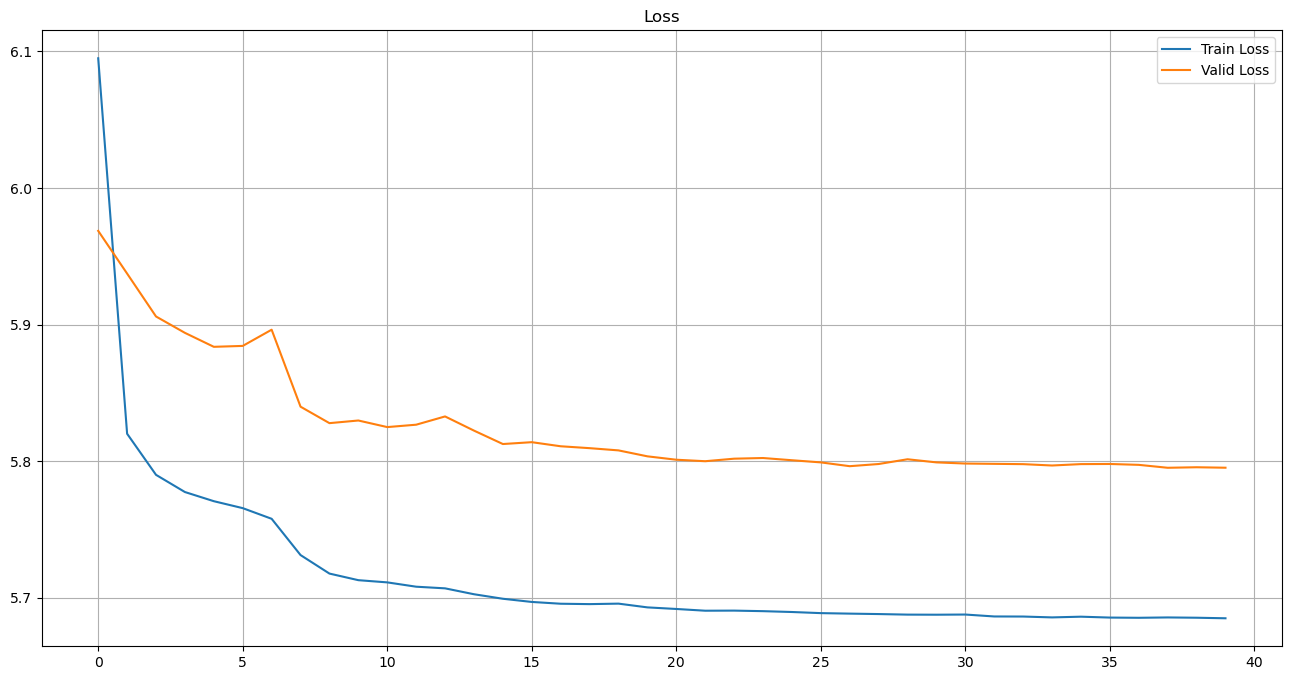

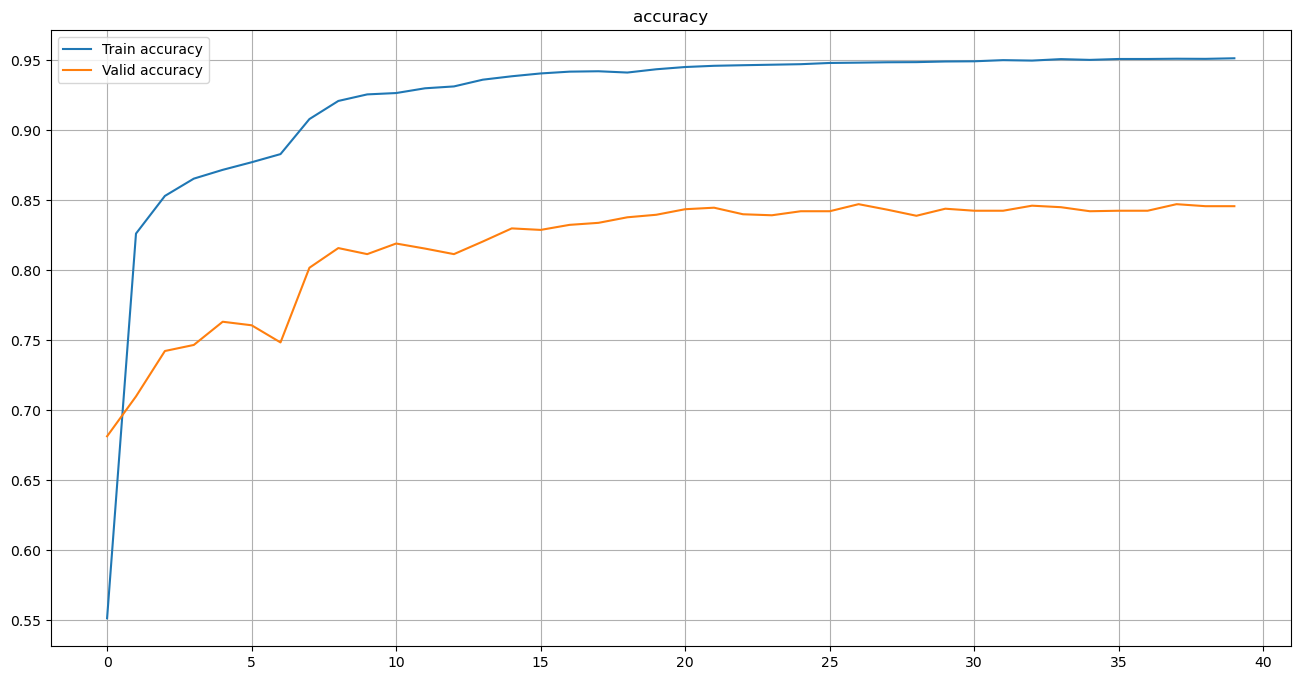

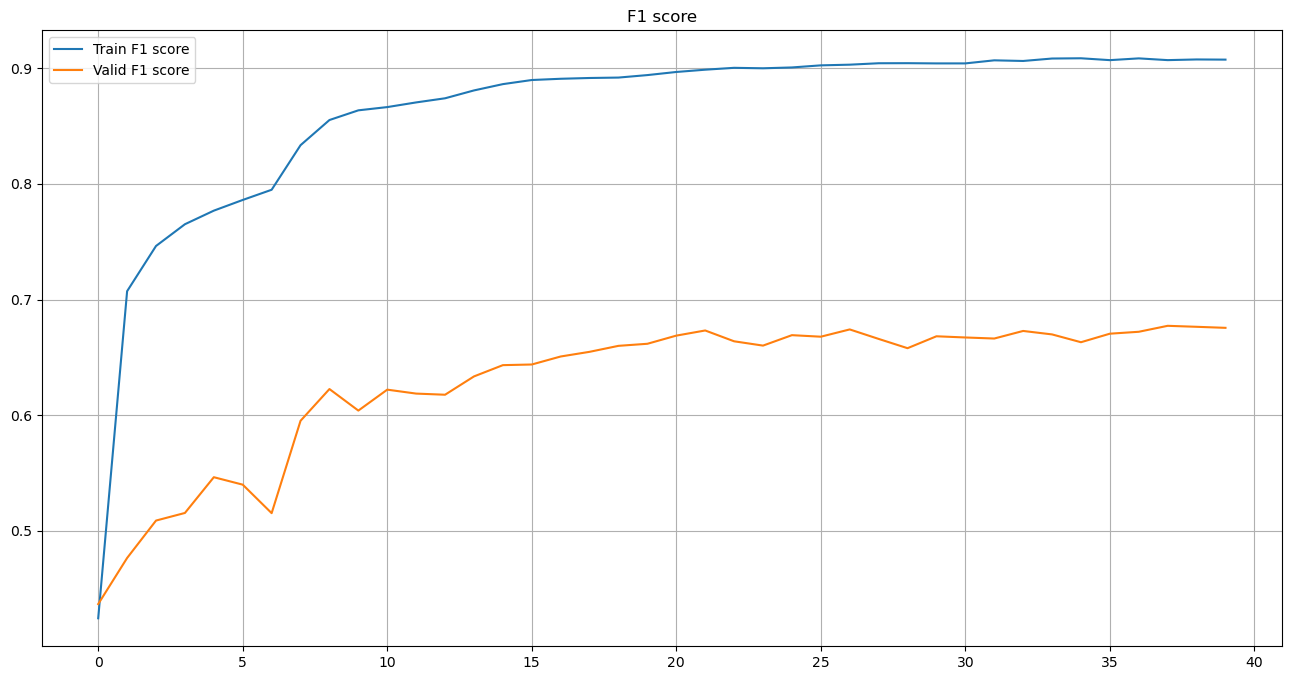

In [68]:
plot_stats(
    **history,
    title=f"Model {config.model_name}"
)

# 8. Result evaluation

In [69]:
embeddings_bag, labels = get_embeddings(model, test_dataloader, device)

Processing: 100%|██████████| 22/22 [00:10<00:00,  2.02batch/s]


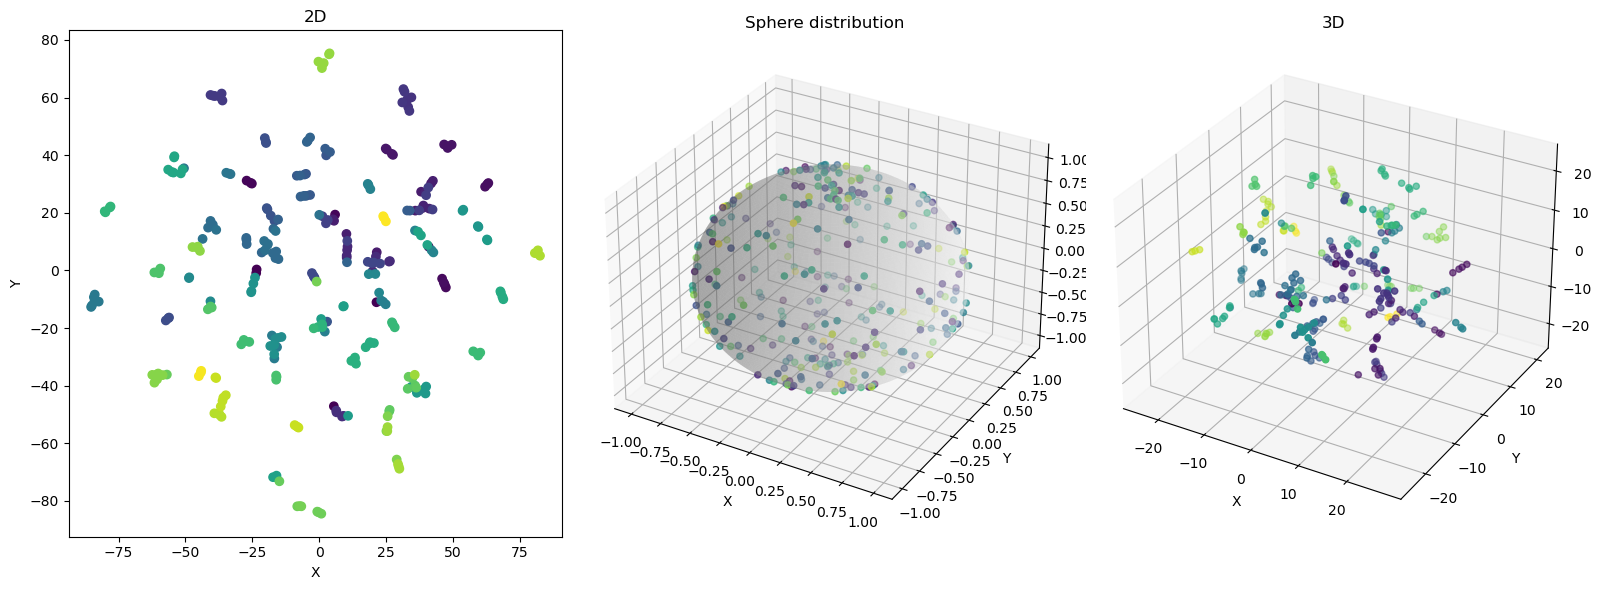

In [70]:
visualize_embeddings(
    embeddings_bag[:300],
    labels[:300],
    reduce_with='tsne',
    # reduce_with='pca',
)

In [71]:
# image = train_dataset[90][0].to(device)
# lab = torch.unsqueeze(torch.tensor(train_dataset[90][1]).to(device).to(torch.long), dim=0)
# model = model.to(device)
#
# criterion3(model(torch.unsqueeze(image, dim=0)), lab)

In [72]:
model.eval()  # Set the model to evaluation mode
predictions = []
correct = 0
total = 0

with torch.no_grad():
    with tqdm(test_dataloader, desc="Processing",unit="batch") as process:
        for images, labels in process:
            images = images.to(device)
            labels = labels.to(device)
            embeddings = model(images)
            probabilities = criterion(embeddings, labels)
            _, predicted = torch.max(probabilities, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            predictions.extend(predicted.cpu().numpy())

            
print_highlighted(f"Manually calculated accuracy: {correct/total}")

Processing: 100%|██████████| 22/22 [00:11<00:00,  1.89batch/s]

Manually calculated accuracy: 0.8457657657657658


In [73]:
c_report = classification_report(test_dataset.labels, np.array(predictions), output_dict=True, zero_division=0)
c_report = pd.DataFrame(c_report).transpose()
c_report

,precision,recall,f1-score,support
0,1.000000,0.500000,0.666667,4.000000
1,1.000000,0.750000,0.857143,4.000000
2,0.750000,0.750000,0.750000,4.000000
3,0.600000,0.750000,0.666667,4.000000
4,1.000000,1.000000,1.000000,4.000000
...,...,...,...,...
758,0.600000,1.000000,0.750000,3.000000
759,1.000000,0.666667,0.800000,3.000000
accuracy,0.845766,0.845766,0.845766,0.845766
macro avg,0.833859,0.840884,0.821103,2775.000000


In [74]:
c_report[c_report['precision'] > 0][:-3].mean()

precision    0.878964
recall       0.886369
f1-score     0.865518
support      3.665742
dtype: float64

In [75]:
accuracy_score(test_dataset.labels, np.array(predictions))

0.8457657657657658

To download the model, use code below:

In [76]:
from IPython.display import FileLink
FileLink(model_file_name)

/kaggle/working/ArcFace_efficientnet_b0.pth